In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Load data

In [2]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

data['accuracy'] = data.accuracy.fillna(0)

## Section 2: Item Description

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:xlabel='accuracy'>

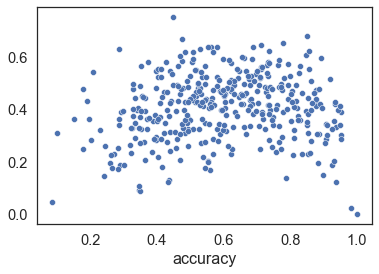

In [3]:
sum_scores = data.groupby('subject').accuracy.sum()
f = lambda x: np.corrcoef(sum_scores[x.subject], x.accuracy)[0,1]
a = data.groupby('item_id').apply(f).fillna(0)
b = data.groupby('item_id').accuracy.mean()
sns.scatterplot(x=b, y=a)

## Section 3: item invariance

In [13]:
dif = read_csv('stan_results/dif.csv')
print('distractor')
print((dif.p1 < 0.05).sum(), (dif.p1 < 0.05).mean())
print((dif.fwe1 < 0.05).sum(), (dif.fwe1 < 0.05).mean())
print('shape set')
print((dif.p2 < 0.05).sum(), (dif.p2 < 0.05).mean())
print((dif.fwe2 < 0.05).sum(), (dif.fwe2 < 0.05).mean())

distractor
46 0.71875
25 0.390625
shape set
35 0.546875
12 0.1875


<AxesSubplot:ylabel='Count'>

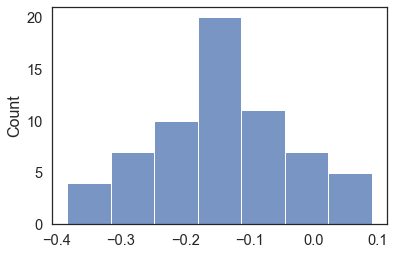

In [25]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

d0 = inv_logit(dif.b0 + dif.b2) - inv_logit(dif.b0)
sns.histplot(d0)

<AxesSubplot:xlabel='fwe2'>

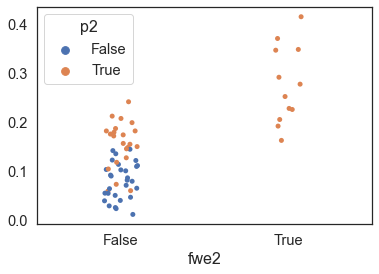

In [40]:
d2 = np.column_stack([
    inv_logit(dif.b0 + dif.b3) - inv_logit(dif.b0),
    inv_logit(dif.b0 + dif.b4) - inv_logit(dif.b0),
    inv_logit(dif.b0 + dif.b4) - inv_logit(dif.b0 + dif.b3)
])

dmax = np.abs(d2).max(axis=1)

sns.stripplot(x=dif.fwe2 < 0.05, y=dmax, hue=dif.p2 < 0.05)

In [111]:
from statsmodels.api import Logit

n_subj = 1500
n_item = 64
n_vers = 6
n_test = 16
gamma = 0.25

np.random.seed(47404)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x - np.mean(x)) / np.std(x)

theta = np.random.normal(0, 1, n_subj)

beta = np.random.normal(0, 1, n_item)
beta = np.repeat(np.sort(beta), n_vers)

alpha = np.exp(np.random.normal(np.log(1/(1-gamma)), 0.15, n_item))
alpha = np.repeat(alpha, n_vers)

J = np.repeat(np.arange(n_subj), n_test)
N = len(J)

a = np.arange(n_item * n_vers // n_test)
b = np.arange(0, n_item * n_vers, a.max()+1)

K = []
for _ in range(n_subj): 
    K = np.concatenate([K, np.random.choice(a, n_test, replace=True) + b]).astype(int)
    
mu = np.zeros(N)
for n in range(N): mu[n] = inv_logit(alpha[K[n]] * theta[J[n]] - beta[K[n]])
    
Y = np.random.binomial(1, gamma + (1-gamma) * mu)
sum_scores = np.array([sum(Y[J==j]) for j in range(n_subj)])

params = []

for k in range(n_item):
    
    ## Define indices
    ix = K // n_vers == k
    
    y = Y[ix]
    
    x0 = np.ones_like(y)
    x1 = zscore(sum_scores[J[ix]] - y)
    x2 = K[ix] % 2
    x3 = np.where(K[ix] % 6 == 1, 1, 0)
    x4 = np.where(K[ix] % 6 == 2, 1, 0)
    
    fit = Logit(y, np.column_stack([x0, x1, x2, x3, x4])).fit(disp=0)
    
    ## Check convergence.
    if not fit.mle_retvals['converged']: 
        continue
        
    params.append(fit.params)
    
params = np.row_stack(params).round(6)

<AxesSubplot:ylabel='Count'>

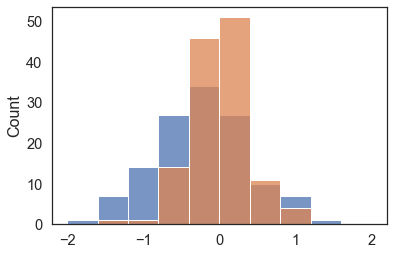

In [122]:
sns.histplot(np.concatenate([dif.b3, dif.b4]), bins=np.linspace(-2,2,11), color='#4c72b0')
sns.histplot(np.concatenate([params[:,3], params[:,4]]), bins=np.linspace(-2,2,11), color='#dd8452')

<AxesSubplot:xlabel='b2', ylabel='Count'>

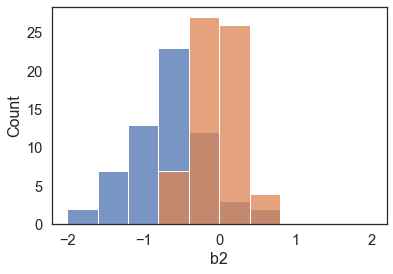

In [127]:
sns.histplot(dif.b2, bins=np.linspace(-2,2,11), color='#4c72b0')
sns.histplot(params[:,2], bins=np.linspace(-2,2,11), color='#dd8452')